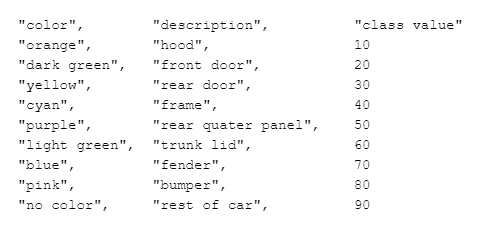

In [1]:
import numpy as np
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam

from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import time

from sklearn.model_selection import train_test_split

# from google.colab import drive
# drive.mount('/content/drive')


# Load the TensorBoard notebook extension
%load_ext tensorboard

torch.cuda.is_available()

C:\Users\uller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
#dir = "drive/MyDrive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/SegCarImg/data/"
dir = "C:/Users/uller/OneDrive - Danmarks Tekniske Universitet/Uni/Kandidat/sem3/Deep/projekt/carseg_data/"

photo_count = 169
orange_count = 2001
black_count = 834

test_images = [dir + 'arrays/photo_{:04d}.npy'.format(i) for i in range(1,photo_count)]
train_orange_3_doors_images = [dir + 'arrays/orange_3_doors_{:04d}.npy'.format(i) for i in range(1,orange_count)]
train_black_5_doors_images = [dir + 'arrays/black_5_doors_{:04d}.npy'.format(i) for i in range(1,black_count)]

# Preprocessing data

Prepare the data for deep learning with dataloaders and staticstial anaylysis


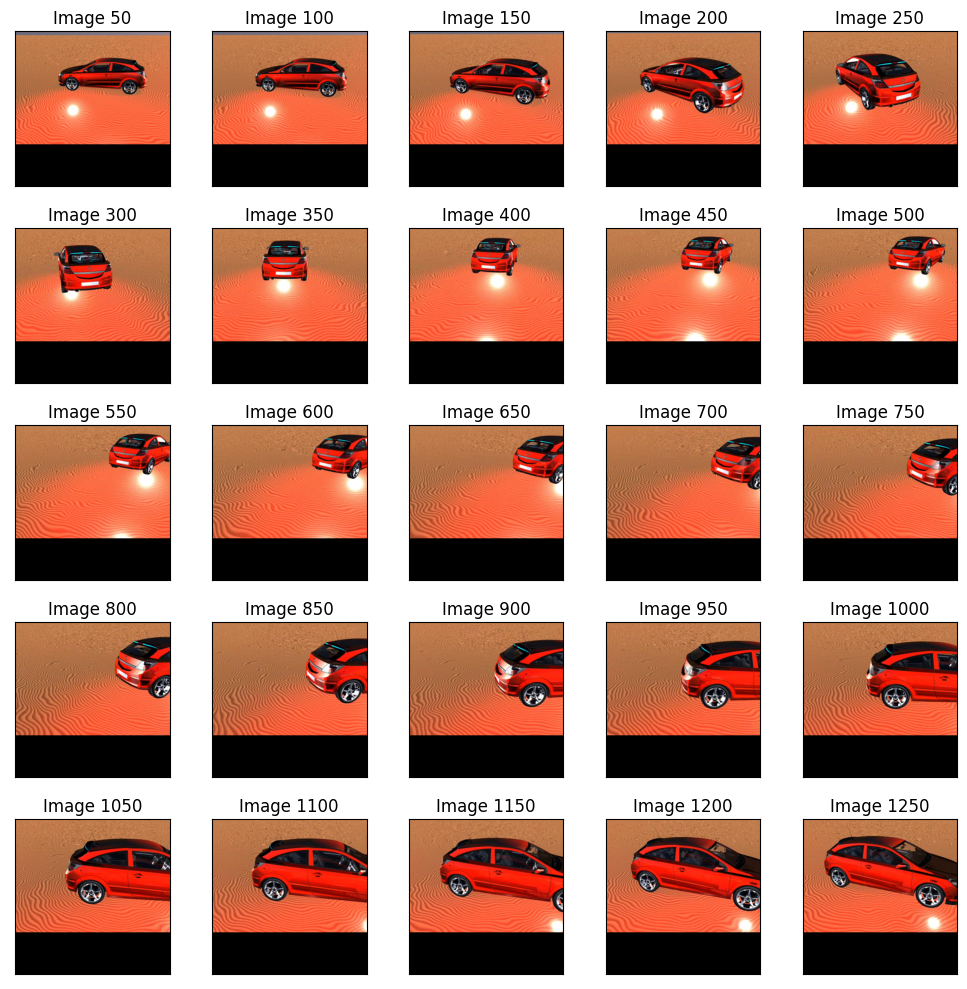

In [3]:
image_data = []
Image_index = 25

#Create image data
for i in range(Image_index):
    #Load dir
    img_dir = train_orange_3_doors_images[i*50]
    #Load array
    array = np.load(img_dir)
    #Reshape array
    img_array = array[:,:,:3]
    #Append data (for Image_index images)
    image_data.append(img_array)


# Create a Matplotlib figure and subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
# Plot the images in the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(image_data[i])
    ax.set_title(f'Image {(i + 1) * 50}')
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping titles
plt.show()

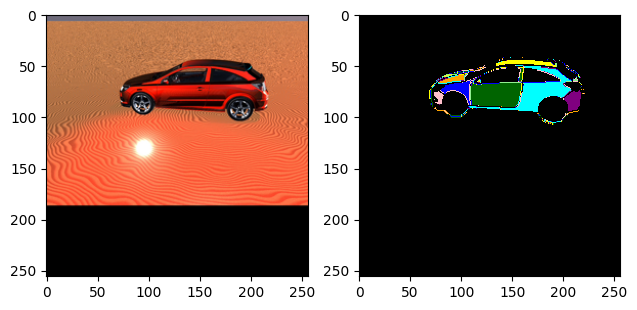

In [4]:
#Load dir
img_dir = train_orange_3_doors_images[2]
#Load array
array = np.load(img_dir)
#Reshape array
img_array = array[:,:,:3]
#Mask Label
mask_array = array[:,:,3]

# Define the classes and their corresponding colors
classes = [0,10, 20, 30, 40, 50, 60, 70, 80, 90]
colors = ['black','orange', 'darkgreen', 'yellow', 'cyan', 'purple', 'lightgreen', 'blue', 'pink', 'black']
# Create a custom colormap
carseg_cmap = ListedColormap(colors, name='custom_cmap')

fig, axs = plt.subplots(1, 2)
# Plot the images in the subplots
axs[0].imshow(img_array)
axs[1].imshow(mask_array, cmap=carseg_cmap)

# Show the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping titles
plt.show()


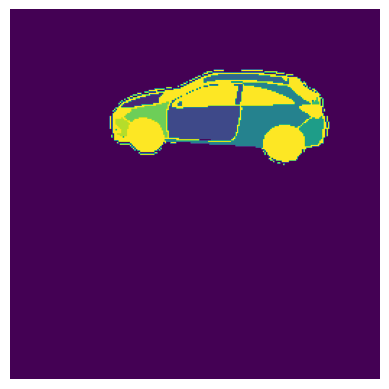

torch.Size([256, 256]) <class 'torch.Tensor'> torch.int64
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [5]:

test = torch.tensor(mask_array)/10
test = test.long()
# # Display the image using Matplotlib
plt.imshow(test)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()
print(test.shape, type(test), test.dtype)

print(test)



# Config


In [6]:
# define the test split
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of number of classes
NUM_CLASSES = 10

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 5
BATCH_SIZE = 32

# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

# define threshold to filter weak predictions
THRESHOLD = 0.5

cuda


# Dataset

In [7]:
class imageArrayDataset(Dataset):
  def __init__(self, arrayPaths, transforms):
    self.arrayPaths = arrayPaths
    self.transforms = transforms

  def __len__(self):
    return len(self.arrayPaths)

  def __getitem__(self, idx):
    #Grab image from index
    arrayPath = self.arrayPaths[idx]
    arrayz = np.load(arrayPath)

    #Preprocessing, reshape image data and mask:
    image = arrayz[:,:,:3]
    mask = arrayz[:,:,3]

    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.transforms(mask)
      # mask = torch.argmax(mask, dim=0) #VIGTIG
      image = torch.from_numpy(image)
      mask = torch.from_numpy(mask)/10
      image = image.permute(2, 0, 1)
      image = image.float()/255
      mask = mask.long()
    else:
      image = torch.from_numpy(image)
      mask = torch.from_numpy(mask)/10
      image = image.permute(2, 0, 1)
      image = image.float()/255
      mask = mask.long()

    return (image,mask)


In [11]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(train_orange_3_doors_images, test_size=TEST_SPLIT,
                         random_state=42)
trainImages = split[0]
testImages   = split[1]

# define transformations
transformsArray = None
# transforms.Compose([transforms.ToTensor()])

# create the train and test datasets
trainDS = imageArrayDataset(arrayPaths=trainImages, transforms=transformsArray)
testDS = imageArrayDataset(arrayPaths=testImages, transforms=transformsArray)

for i in range(len(trainDS)):
            data, label = trainDS[i]

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=0)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=0)


# Unet

In [9]:
# https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        #""" Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        #""" Bottleneck """
        self.b = conv_block(512, 1024)
        #""" Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        #""" Classifier """
        self.outputs = nn.Conv2d(64, NUM_CLASSES, kernel_size=1, padding=0)
    def forward(self, inputs):
        #""" Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        #""" Bottleneck """
        b = self.b(p4)
        #""" Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        #""" Classifier """
        outputs = self.outputs(d4)
        return outputs

# Train

In [12]:
# initialize our UNet model
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

In [13]:
# Check tensor shapes
batch = next(iter(trainLoader))
images, mask = batch
print(images.shape, mask.shape, type(images), type(mask), images.dtype, mask.dtype)

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64


In [14]:
test = torch.rand(32,10,256,256, dtype=torch.float32)
print()

criterion(test, mask)

tensor(2.3399)

In [ ]:
##%tensorboard --logdir logs

In [15]:
#Training LOOP
torch.cuda.empty_cache()

# Create a TensorBoard writer
# writer = SummaryWriter('logs')

step_losses  = []
epoch_losses = []

for epoch in tqdm(range(NUM_EPOCHS)):
    unet.train()
    epoch_loss = 0
    for X, Y in tqdm(trainLoader, total=len(trainLoader), leave=False):
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        opt.zero_grad()
        Y_pred = unet(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())

        # Log loss and other metrics to TensorBoard
        # writer.add_scalar('Loss', loss, global_step=epoch)

# Close the TensorBoard writer
# writer.close()

  0%|          | 0/5 [23:51<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "U-Net-PRE_ALPHA.pth"
torch.save(unet.state_dict(), model_name)

In [ ]:
X, Y = next(iter(testLoader))
X, Y = X.to(DEVICE), Y.to(DEVICE)
Y_pred = unet(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

In [ ]:
test_batch_size=3
# fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

# for i in range(test_batch_size):

#     landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
#     label_class = Y[i].cpu().detach().numpy()
#     label_class_predicted = Y_pred[i].cpu().detach().numpy()

#     axes[i, 0].imshow(landscape)
#     axes[i, 0].set_title("Landscape")
#     axes[i, 1].imshow(label_class)
#     axes[i, 1].set_title("Label Class")
#     axes[i, 2].imshow(label_class_predicted)
#     axes[i, 2].set_title("Label Class - Predicted")

landscape = X[0].permute(1, 2, 0).cpu().detach().numpy()
label_class = mask[0].cpu().detach().numpy()
label_class_predicted = Y_pred[0].cpu().detach().numpy()
print(label_class)
fig, axs = plt.subplots(1, 2)
# Plot the images in the subplots
axs[0].imshow(landscape)
axs[1].imshow(label_class, cmap=carseg_cmap)

# Show the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping titles
plt.show()